In [1]:
from paretoCardinalityRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [ ]:
#function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
    '''
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    return sampled_simMatrix, sampled_item_ids

def findApproximateParetoSolutions(simMatrix, item_ids, sample_size, num_runs=10, k_max=30, dataset_name=""):
    '''
    Run algorithms over multiple random samples of the dataset, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        sample_size (int): Number of items to sample from the dataset.
        num_runs (int): Number of independent runs.
        k_max (int): Maximum cardinality.
        dataset_name (str): Name of the dataset for plotting.
    '''
    algo_names = ["ParetoGreedy", "TopK", "Random"]
    # containers across samples
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    print(f"Starting processing {num_runs} runs with sample size {sample_size} and k_max {k_max}")
   
    # iterate runs
    for run in range(num_runs):
        
        print(f"Processing run {run + 1}/{num_runs}")
        
        # per-run containers
        sample_objectives = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}
        
        # sample the dataset
        sampled_simMatrix, sampled_item_ids = sample_dataset(simMatrix, item_ids, sample_size)
        # sample_signature = hash(tuple(sampled_item_ids))
        # print(f"Run {run + 1} sample signature: {sample_signature}")
       
        # Initialize Pareto cardinality restaurants object
        paretoCard = paretoCardinalityRestaurants(n_items=sampled_item_ids, simMatrix=sampled_simMatrix, k_max=k_max)
        
        # Greedy Cardinality
        _, _, _, runTime = paretoCard.greedyCardinality()
        objectives = []
        current_objective = 0
        for k in range(1, k_max + 1):
            if k in paretoCard.kSolDict:
                current_objective = paretoCard.kSolDict[k]['Objective']
            objectives.append(current_objective)
        sample_objectives['ParetoGreedy'] = objectives
        sample_runtimes['ParetoGreedy'] = runTime
        
        # Top K
        paretoCard2 = paretoCardinalityRestaurants(n_items=sampled_item_ids, simMatrix=sampled_simMatrix, k_max=k_max)
        _, _, _, runTime = paretoCard2.top_k()
        objectives = [paretoCard2.kSolDict[k]['Objective'] for k in range(1, k_max + 1)]
        sample_objectives['TopK'] = objectives
        sample_runtimes['TopK'] = runTime
        
        # Random
        paretoCard3 = paretoCardinalityRestaurants(n_items=sampled_item_ids, simMatrix=sampled_simMatrix, k_max=k_max)
        _, _, _, runTime = paretoCard3.random_selection()
        objectives = [paretoCard3.kSolDict[k]['Objective'] for k in range(1, k_max + 1)]
        sample_objectives['Random'] = objectives
        sample_runtimes['Random'] = runTime
       
        # convert per-run lists to numpy arrays and store
        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            all_objectives[alg].append(arr)
            all_runtimes[alg].append(sample_runtimes[alg])
    
    # compute mean and std across runs for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (num_runs, k_max)
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 1.0  # 1 std deviation
    
    # Plot mean objective with shaded std band (consistent with influence formatting)
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    markers = ['o', 's', '^', 'v', 'D']
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'
        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy":
            color = colors[3]
            marker = "D"
            zorder = 4
        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(range(1, k_max + 1), mean, label=label, color=color, linestyle=line_style, marker=marker, markersize=marker_size, markeredgewidth=1.1, markeredgecolor='k', linewidth=1.8, zorder=zorder)
        ax.fill_between(range(1, k_max + 1), np.clip(mean - std, 0, None), mean + std, color=color, alpha=0.18, zorder=2)
    
    ax.set_xlabel(r'Cardinality ($k$)', fontsize=24)
    ax.set_ylabel(r'Mean objective ($\bar{f}$)', fontsize=24)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=20)
    
    # Legend inside bottom right
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=18, frameon=True)
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### Yelp Phoenix Experiments

In [3]:
#Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

2026-01-26 16:59:17,753 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50


Starting processing 15 runs with sample size 300 and k_max 50
Processing run 1/15
Run 1 sample signature: 2851791691560087691


2026-01-26 16:59:19,361 |INFO: Cardinality Greedy Solution:[169, 52, 150, 186, 29, 47, 105, 110, 82, 281, 209, 284, 248, 65, 49, 93, 68, 239, 196, 104, 240, 292, 164, 282, 83, 253, 190, 278, 13, 175, 206, 137, 84, 212, 179, 294, 222, 251, 134, 189, 109, 144, 274, 255, 185, 191, 7, 98, 67, 221], Objective:106.202, Runtime = 1.61 seconds
2026-01-26 16:59:19,362 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:19,672 |INFO: Top-k Solution:[169, 110, 275, 71, 182, 104, 204, 6, 227, 73, 80, 232, 52, 240, 190, 282, 199, 181, 82, 229, 245, 266, 281, 150, 137, 297, 41, 89, 162, 107, 76, 1, 105, 212, 279, 157, 65, 148, 22, 109, 124, 132, 49, 29, 14, 183, 138, 48, 47, 74], Objective:86.125, Runtime = 0.31 seconds
2026-01-26 16:59:19,673 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:19,817 |INFO: Random Selection Solution:[np.int64(157), np.int64(177), np.int64(55), n

Processing run 2/15
Run 2 sample signature: 3523675782455126151


2026-01-26 16:59:21,325 |INFO: Cardinality Greedy Solution:[206, 66, 144, 146, 85, 142, 47, 263, 45, 123, 147, 188, 4, 97, 158, 102, 74, 88, 56, 194, 233, 111, 171, 13, 21, 270, 244, 227, 181, 299, 5, 1, 173, 220, 83, 190, 283, 261, 248, 50, 214, 12, 296, 288, 130, 19, 35, 262, 265, 30], Objective:104.697, Runtime = 1.51 seconds
2026-01-26 16:59:21,326 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:21,646 |INFO: Top-k Solution:[206, 78, 53, 248, 97, 142, 28, 250, 180, 66, 110, 146, 109, 281, 288, 175, 176, 29, 85, 213, 285, 268, 170, 123, 51, 254, 100, 130, 158, 263, 94, 229, 270, 74, 279, 96, 230, 247, 269, 223, 167, 239, 226, 292, 102, 205, 242, 107, 202, 18], Objective:85.322, Runtime = 0.32 seconds
2026-01-26 16:59:21,647 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:21,796 |INFO: Random Selection Solution:[np.int64(279), np.int64(182), np.int64(225),

Processing run 3/15
Run 3 sample signature: 5994138795430389433


2026-01-26 16:59:23,466 |INFO: Cardinality Greedy Solution:[127, 200, 42, 77, 211, 210, 24, 287, 284, 19, 203, 188, 79, 234, 37, 266, 137, 182, 239, 155, 277, 221, 276, 162, 30, 204, 183, 259, 299, 90, 16, 285, 233, 55, 102, 217, 68, 119, 156, 190, 227, 96, 288, 44, 89, 184, 189, 199, 41, 138], Objective:106.187, Runtime = 1.67 seconds
2026-01-26 16:59:23,467 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:23,774 |INFO: Top-k Solution:[127, 167, 266, 93, 130, 263, 194, 201, 44, 139, 55, 226, 77, 50, 287, 75, 137, 112, 195, 230, 176, 34, 147, 59, 192, 62, 150, 42, 234, 213, 19, 264, 277, 243, 79, 81, 282, 238, 10, 166, 116, 198, 258, 275, 200, 58, 48, 154, 64, 204], Objective:81.900, Runtime = 0.31 seconds
2026-01-26 16:59:23,775 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:23,932 |INFO: Random Selection Solution:[np.int64(272), np.int64(234), np.int64(136

Processing run 4/15
Run 4 sample signature: 3418948008789784955


2026-01-26 16:59:25,499 |INFO: Cardinality Greedy Solution:[39, 90, 190, 218, 83, 28, 58, 270, 196, 45, 59, 76, 3, 279, 209, 56, 16, 266, 167, 4, 197, 174, 123, 9, 125, 154, 291, 74, 229, 191, 144, 25, 60, 63, 207, 210, 135, 228, 236, 87, 8, 81, 221, 202, 54, 188, 297, 66, 49, 253], Objective:107.865, Runtime = 1.56 seconds
2026-01-26 16:59:25,499 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:25,800 |INFO: Top-k Solution:[39, 271, 97, 291, 190, 254, 245, 113, 44, 294, 187, 82, 197, 107, 167, 76, 54, 172, 173, 91, 221, 83, 94, 171, 50, 5, 246, 235, 28, 281, 60, 148, 52, 130, 56, 289, 99, 293, 162, 229, 180, 90, 176, 70, 49, 22, 74, 57, 255, 2], Objective:82.726, Runtime = 0.30 seconds
2026-01-26 16:59:25,800 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:25,948 |INFO: Random Selection Solution:[np.int64(298), np.int64(169), np.int64(282), np.int64(127), np

Processing run 5/15
Run 5 sample signature: 9105269773183444031


2026-01-26 16:59:27,533 |INFO: Cardinality Greedy Solution:[277, 62, 76, 130, 138, 230, 92, 81, 199, 47, 98, 267, 161, 105, 190, 177, 29, 74, 137, 261, 198, 192, 239, 244, 60, 23, 216, 264, 295, 110, 227, 112, 103, 196, 123, 232, 205, 187, 266, 298, 115, 212, 14, 178, 107, 84, 287, 100, 49, 147], Objective:109.157, Runtime = 1.58 seconds
2026-01-26 16:59:27,534 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:27,842 |INFO: Top-k Solution:[277, 46, 118, 271, 81, 227, 187, 211, 159, 22, 242, 138, 94, 140, 126, 165, 76, 110, 191, 231, 200, 230, 280, 7, 1, 141, 0, 109, 84, 166, 29, 237, 260, 72, 62, 70, 154, 156, 205, 161, 11, 67, 130, 273, 245, 203, 169, 157, 190, 31], Objective:83.045, Runtime = 0.31 seconds
2026-01-26 16:59:27,843 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:27,994 |INFO: Random Selection Solution:[np.int64(285), np.int64(210), np.int64(27)

Processing run 6/15
Run 6 sample signature: 9178830007830497559


2026-01-26 16:59:29,516 |INFO: Cardinality Greedy Solution:[191, 14, 66, 133, 86, 271, 168, 269, 275, 250, 127, 40, 75, 59, 175, 267, 17, 202, 205, 254, 41, 245, 165, 31, 203, 178, 55, 246, 102, 1, 64, 61, 12, 77, 177, 108, 225, 233, 49, 10, 72, 171, 249, 160, 9, 73, 104, 117, 268, 277], Objective:107.594, Runtime = 1.52 seconds
2026-01-26 16:59:29,517 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:29,821 |INFO: Top-k Solution:[191, 213, 86, 47, 266, 75, 36, 243, 224, 165, 30, 201, 17, 85, 62, 123, 70, 189, 66, 78, 65, 99, 135, 14, 6, 175, 20, 193, 128, 271, 38, 31, 105, 144, 249, 133, 101, 177, 264, 76, 246, 142, 242, 267, 115, 171, 118, 102, 176, 90], Objective:84.851, Runtime = 0.30 seconds
2026-01-26 16:59:29,822 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:29,971 |INFO: Random Selection Solution:[np.int64(79), np.int64(55), np.int64(139), np.int64(2

Processing run 7/15
Run 7 sample signature: 6715475363401152245


2026-01-26 16:59:31,674 |INFO: Cardinality Greedy Solution:[267, 259, 97, 283, 204, 113, 256, 99, 147, 80, 213, 127, 222, 33, 38, 87, 243, 143, 168, 293, 64, 134, 86, 178, 245, 183, 78, 123, 228, 275, 59, 118, 200, 48, 252, 217, 224, 277, 223, 249, 225, 35, 292, 158, 202, 251, 89, 151, 27, 67], Objective:105.753, Runtime = 1.70 seconds
2026-01-26 16:59:31,675 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:31,979 |INFO: Top-k Solution:[267, 53, 33, 204, 221, 56, 64, 182, 189, 294, 97, 265, 109, 142, 147, 71, 73, 101, 161, 263, 123, 274, 224, 206, 60, 247, 54, 143, 70, 144, 245, 256, 288, 28, 172, 163, 216, 220, 196, 283, 148, 128, 225, 39, 57, 235, 129, 193, 121, 234], Objective:81.597, Runtime = 0.30 seconds
2026-01-26 16:59:31,981 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:32,125 |INFO: Random Selection Solution:[np.int64(55), np.int64(87), np.int64(3

Processing run 8/15
Run 8 sample signature: 5593904607151948625


2026-01-26 16:59:33,673 |INFO: Cardinality Greedy Solution:[286, 146, 18, 215, 244, 39, 112, 243, 16, 168, 171, 20, 267, 276, 274, 191, 241, 33, 136, 272, 232, 7, 185, 56, 81, 101, 228, 133, 273, 43, 250, 67, 293, 164, 231, 209, 292, 212, 174, 84, 87, 111, 277, 197, 143, 83, 147, 242, 13, 152], Objective:109.439, Runtime = 1.55 seconds
2026-01-26 16:59:33,674 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:33,991 |INFO: Top-k Solution:[286, 63, 246, 62, 276, 78, 253, 109, 263, 8, 243, 215, 165, 145, 272, 50, 274, 176, 168, 205, 139, 241, 23, 43, 47, 3, 71, 72, 191, 79, 295, 178, 255, 96, 146, 119, 209, 219, 290, 244, 100, 208, 285, 218, 107, 136, 9, 87, 55, 67], Objective:83.834, Runtime = 0.32 seconds
2026-01-26 16:59:33,992 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:34,141 |INFO: Random Selection Solution:[np.int64(109), np.int64(298), np.int64(76), n

Processing run 9/15
Run 9 sample signature: -1166993660552778541


2026-01-26 16:59:35,704 |INFO: Cardinality Greedy Solution:[100, 45, 288, 125, 141, 41, 65, 9, 163, 240, 137, 67, 142, 297, 171, 187, 181, 166, 129, 219, 61, 127, 76, 55, 244, 52, 34, 14, 159, 224, 208, 49, 28, 193, 115, 128, 21, 80, 132, 31, 22, 46, 242, 57, 273, 27, 99, 246, 66, 114], Objective:109.988, Runtime = 1.56 seconds
2026-01-26 16:59:35,705 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:36,007 |INFO: Top-k Solution:[100, 291, 118, 269, 42, 65, 294, 151, 282, 288, 73, 256, 36, 77, 250, 186, 125, 80, 16, 104, 224, 218, 200, 91, 70, 67, 238, 45, 170, 114, 241, 137, 75, 41, 163, 260, 281, 95, 171, 240, 268, 101, 198, 128, 149, 82, 237, 62, 72, 126], Objective:88.082, Runtime = 0.30 seconds
2026-01-26 16:59:36,008 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:36,153 |INFO: Random Selection Solution:[np.int64(182), np.int64(14), np.int64(295), np.int

Processing run 10/15
Run 10 sample signature: 1951771139818442664


2026-01-26 16:59:37,692 |INFO: Cardinality Greedy Solution:[4, 87, 288, 228, 163, 161, 275, 77, 90, 60, 71, 14, 265, 229, 219, 95, 222, 159, 154, 266, 55, 96, 124, 263, 162, 153, 26, 130, 244, 147, 273, 252, 18, 212, 133, 223, 15, 24, 88, 37, 61, 34, 10, 85, 168, 194, 48, 180, 186, 151], Objective:108.231, Runtime = 1.54 seconds
2026-01-26 16:59:37,693 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:38,004 |INFO: Top-k Solution:[4, 275, 144, 167, 288, 238, 113, 215, 55, 269, 7, 222, 11, 93, 176, 228, 87, 60, 262, 96, 155, 111, 31, 193, 229, 219, 226, 84, 194, 59, 278, 257, 53, 83, 199, 266, 77, 130, 135, 28, 159, 102, 276, 163, 223, 152, 285, 239, 114, 252], Objective:88.306, Runtime = 0.31 seconds
2026-01-26 16:59:38,005 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:38,151 |INFO: Random Selection Solution:[np.int64(275), np.int64(282), np.int64(77), np.in

Processing run 11/15
Run 11 sample signature: -3709480661337675198


2026-01-26 16:59:39,775 |INFO: Cardinality Greedy Solution:[175, 149, 42, 227, 122, 107, 190, 110, 273, 267, 238, 151, 77, 286, 33, 193, 222, 255, 5, 63, 249, 185, 138, 18, 41, 272, 99, 248, 146, 95, 30, 125, 21, 230, 252, 233, 290, 295, 298, 202, 60, 280, 59, 54, 242, 103, 278, 232, 74, 254], Objective:104.541, Runtime = 1.62 seconds
2026-01-26 16:59:39,775 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:40,075 |INFO: Top-k Solution:[175, 105, 227, 183, 193, 221, 198, 215, 172, 42, 197, 41, 212, 247, 117, 211, 230, 282, 15, 31, 111, 293, 267, 255, 63, 285, 94, 23, 266, 243, 273, 205, 57, 232, 148, 107, 210, 281, 271, 234, 143, 76, 149, 283, 47, 130, 222, 240, 90, 265], Objective:82.846, Runtime = 0.30 seconds
2026-01-26 16:59:40,075 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:40,221 |INFO: Random Selection Solution:[np.int64(102), np.int64(121), np.int6

Processing run 12/15
Run 12 sample signature: 2493016753138819767


2026-01-26 16:59:41,917 |INFO: Cardinality Greedy Solution:[93, 237, 53, 191, 197, 220, 84, 254, 136, 288, 7, 129, 151, 79, 33, 235, 119, 107, 96, 169, 182, 176, 297, 45, 9, 48, 152, 78, 49, 290, 67, 146, 229, 97, 124, 132, 75, 108, 109, 173, 134, 86, 25, 256, 198, 174, 184, 161, 88, 110], Objective:104.444, Runtime = 1.69 seconds
2026-01-26 16:59:41,918 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:42,218 |INFO: Top-k Solution:[93, 197, 136, 61, 176, 18, 134, 275, 9, 126, 143, 203, 147, 27, 34, 122, 26, 78, 83, 231, 5, 251, 74, 53, 2, 72, 170, 96, 100, 73, 129, 290, 174, 160, 77, 103, 0, 151, 13, 186, 294, 115, 299, 42, 98, 32, 271, 121, 198, 194], Objective:82.291, Runtime = 0.30 seconds
2026-01-26 16:59:42,219 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:42,365 |INFO: Random Selection Solution:[np.int64(229), np.int64(109), np.int64(202), np.int64(42

Processing run 13/15
Run 13 sample signature: 8534940329008958097


2026-01-26 16:59:43,918 |INFO: Cardinality Greedy Solution:[210, 155, 12, 67, 75, 60, 132, 79, 212, 127, 245, 3, 76, 293, 154, 162, 167, 84, 241, 267, 45, 43, 259, 126, 160, 47, 91, 22, 66, 183, 229, 262, 207, 246, 141, 213, 37, 202, 224, 235, 134, 90, 105, 228, 288, 242, 129, 297, 119, 215], Objective:107.113, Runtime = 1.55 seconds
2026-01-26 16:59:43,918 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:44,221 |INFO: Top-k Solution:[210, 126, 75, 263, 130, 19, 112, 268, 259, 177, 225, 245, 38, 238, 125, 148, 18, 271, 66, 244, 98, 9, 17, 93, 172, 73, 224, 12, 20, 266, 155, 265, 92, 262, 183, 151, 45, 223, 54, 156, 84, 181, 67, 161, 288, 226, 250, 42, 276, 48], Objective:85.495, Runtime = 0.30 seconds
2026-01-26 16:59:44,222 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:44,367 |INFO: Random Selection Solution:[np.int64(81), np.int64(119), np.int64(286), np.

Processing run 14/15
Run 14 sample signature: 6753515782674084373


2026-01-26 16:59:45,990 |INFO: Cardinality Greedy Solution:[136, 163, 193, 246, 152, 82, 232, 118, 84, 179, 37, 64, 60, 185, 205, 131, 124, 192, 70, 57, 119, 217, 110, 15, 272, 204, 154, 49, 97, 139, 156, 279, 46, 275, 31, 28, 109, 138, 32, 111, 90, 257, 244, 149, 189, 199, 240, 52, 174, 168], Objective:104.665, Runtime = 1.62 seconds
2026-01-26 16:59:45,991 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:46,303 |INFO: Top-k Solution:[136, 142, 238, 269, 289, 84, 60, 243, 143, 225, 278, 118, 279, 39, 58, 209, 246, 173, 146, 251, 119, 109, 189, 163, 126, 101, 199, 171, 110, 57, 216, 239, 178, 10, 37, 205, 120, 78, 68, 274, 9, 20, 214, 149, 124, 203, 204, 156, 83, 258], Objective:86.534, Runtime = 0.31 seconds
2026-01-26 16:59:46,304 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:46,454 |INFO: Random Selection Solution:[np.int64(32), np.int64(261), np.int64(2

Processing run 15/15
Run 15 sample signature: 8487832467904904864


2026-01-26 16:59:48,021 |INFO: Cardinality Greedy Solution:[36, 285, 175, 250, 131, 146, 55, 280, 247, 156, 209, 123, 100, 222, 274, 298, 205, 2, 81, 281, 148, 77, 86, 124, 240, 104, 22, 99, 16, 224, 197, 137, 144, 143, 207, 87, 170, 264, 78, 120, 35, 142, 177, 24, 130, 168, 65, 169, 245, 295], Objective:111.098, Runtime = 1.56 seconds
2026-01-26 16:59:48,022 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:48,322 |INFO: Top-k Solution:[36, 214, 148, 293, 77, 274, 39, 286, 131, 29, 177, 240, 175, 136, 30, 61, 215, 9, 122, 265, 237, 14, 174, 139, 125, 182, 157, 165, 140, 123, 64, 155, 146, 186, 193, 248, 159, 194, 254, 179, 31, 104, 163, 241, 195, 107, 253, 285, 47, 130], Objective:83.767, Runtime = 0.30 seconds
2026-01-26 16:59:48,322 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-26 16:59:48,471 |INFO: Random Selection Solution:[np.int64(33), np.int64(66), np.int64(

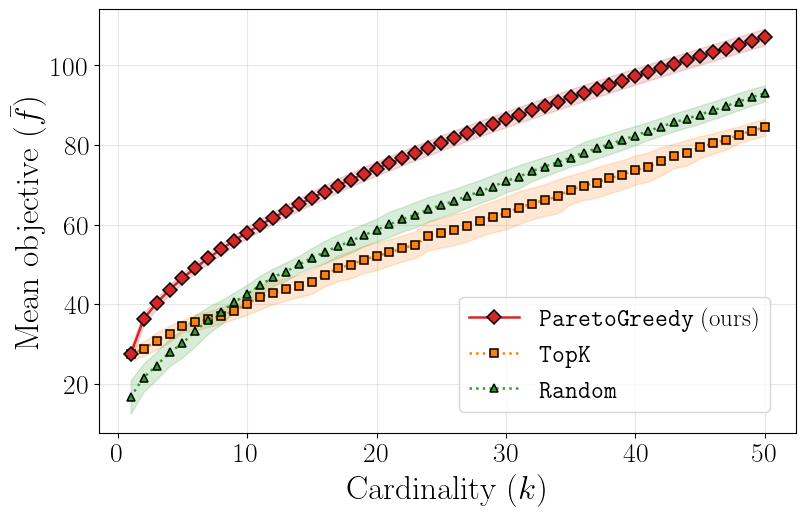

2026-01-26 16:59:49,215 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy: 1.589 ± 0.059
  - TopK: 0.306 ± 0.006
  - Random: 0.147 ± 0.003


In [4]:
#Adjust parameters as needed
sample_size = 300
num_runs = 15  #number of random runs
k_max = 50
findApproximateParetoSolutions(phoenix_simMatrix, phoenix_ids, sample_size, num_runs, k_max, "Yelp_Phoenix")

### Yelp Vegas Experiments

In [5]:
#Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

2026-01-26 16:59:49,289 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50


Starting processing 15 runs with sample size 500 and k_max 50
Processing run 1/15
Run 1 sample signature: -6850316294605535826


2026-01-26 16:59:53,108 |INFO: Cardinality Greedy Solution:[446, 96, 235, 228, 493, 496, 488, 60, 378, 362, 355, 363, 80, 470, 22, 158, 258, 185, 389, 210, 21, 62, 428, 202, 50, 279, 113, 190, 441, 32, 422, 245, 318, 55, 281, 65, 199, 420, 477, 152, 456, 414, 404, 251, 296, 351, 104, 227, 69, 277], Objective:154.688, Runtime = 3.82 seconds
2026-01-26 16:59:53,108 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 16:59:53,657 |INFO: Top-k Solution:[446, 213, 378, 77, 372, 457, 389, 375, 151, 415, 493, 22, 470, 97, 272, 72, 94, 199, 154, 483, 370, 330, 436, 145, 404, 248, 468, 125, 21, 349, 314, 228, 487, 458, 185, 443, 88, 428, 268, 249, 492, 136, 245, 146, 82, 80, 390, 402, 363, 376], Objective:104.727, Runtime = 0.55 seconds
2026-01-26 16:59:53,658 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 16:59:53,923 |INFO: Random Selection Solution:[np.int64(210), np.int64(490),

Processing run 2/15
Run 2 sample signature: 1087033485503773548


2026-01-26 16:59:57,821 |INFO: Cardinality Greedy Solution:[261, 201, 120, 420, 23, 454, 459, 345, 323, 377, 107, 163, 402, 260, 104, 45, 170, 246, 397, 317, 268, 299, 285, 89, 457, 217, 498, 133, 400, 34, 336, 229, 265, 75, 353, 179, 223, 474, 422, 255, 194, 366, 53, 239, 485, 123, 54, 93, 368, 226], Objective:152.768, Runtime = 3.89 seconds
2026-01-26 16:59:57,822 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 16:59:58,385 |INFO: Top-k Solution:[261, 170, 13, 85, 398, 217, 201, 363, 179, 23, 420, 292, 331, 319, 137, 353, 238, 316, 473, 208, 284, 19, 488, 167, 402, 204, 268, 446, 330, 131, 421, 426, 239, 416, 459, 87, 429, 122, 287, 422, 103, 60, 107, 265, 395, 147, 44, 344, 150, 309], Objective:110.272, Runtime = 0.56 seconds
2026-01-26 16:59:58,386 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 16:59:58,649 |INFO: Random Selection Solution:[np.int64(482), np.int64(

Processing run 3/15
Run 3 sample signature: 2211375196791524920


2026-01-26 17:00:03,158 |INFO: Cardinality Greedy Solution:[446, 150, 341, 115, 487, 117, 452, 375, 107, 93, 474, 86, 6, 134, 316, 217, 32, 326, 344, 168, 414, 263, 11, 420, 126, 118, 460, 245, 480, 143, 445, 76, 276, 47, 441, 197, 38, 212, 201, 196, 492, 222, 135, 30, 167, 332, 331, 451, 25, 17], Objective:156.605, Runtime = 4.51 seconds
2026-01-26 17:00:03,159 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:03,723 |INFO: Top-k Solution:[446, 62, 474, 142, 469, 32, 388, 295, 115, 470, 59, 170, 243, 497, 316, 424, 57, 50, 407, 291, 499, 423, 38, 126, 233, 226, 235, 265, 135, 281, 482, 141, 275, 222, 160, 327, 248, 193, 251, 194, 341, 261, 161, 190, 6, 410, 401, 451, 117, 10], Objective:105.548, Runtime = 0.56 seconds
2026-01-26 17:00:03,723 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:03,980 |INFO: Random Selection Solution:[np.int64(27), np.int64(424), n

Processing run 4/15
Run 4 sample signature: 6303513723015621706


2026-01-26 17:00:07,879 |INFO: Cardinality Greedy Solution:[310, 389, 309, 106, 49, 236, 317, 375, 201, 177, 355, 422, 308, 404, 150, 193, 492, 305, 114, 469, 212, 480, 217, 374, 37, 186, 495, 40, 358, 418, 407, 470, 154, 377, 87, 343, 84, 256, 146, 456, 258, 159, 237, 461, 5, 285, 6, 387, 498, 450], Objective:155.187, Runtime = 3.89 seconds
2026-01-26 17:00:07,880 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:08,441 |INFO: Top-k Solution:[310, 375, 81, 308, 251, 205, 82, 316, 422, 174, 144, 407, 222, 469, 150, 494, 314, 0, 309, 392, 276, 389, 103, 223, 268, 299, 269, 267, 456, 436, 162, 45, 462, 106, 460, 278, 180, 483, 176, 128, 279, 1, 362, 167, 89, 458, 441, 155, 93, 154], Objective:110.230, Runtime = 0.56 seconds
2026-01-26 17:00:08,441 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:08,720 |INFO: Random Selection Solution:[np.int64(0), np.int64(307),

Processing run 5/15
Run 5 sample signature: 5130769620677850026


2026-01-26 17:00:12,789 |INFO: Cardinality Greedy Solution:[211, 65, 379, 291, 355, 39, 336, 204, 222, 455, 470, 401, 242, 165, 163, 466, 111, 327, 477, 148, 250, 405, 288, 84, 132, 117, 465, 307, 21, 181, 354, 78, 11, 220, 386, 12, 400, 373, 51, 342, 387, 140, 203, 202, 4, 57, 60, 321, 133, 88], Objective:159.375, Runtime = 4.06 seconds
2026-01-26 17:00:12,790 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:13,340 |INFO: Top-k Solution:[211, 261, 355, 331, 455, 254, 407, 184, 103, 134, 414, 39, 494, 477, 30, 421, 53, 283, 242, 65, 86, 400, 464, 345, 21, 125, 225, 119, 417, 235, 81, 437, 307, 123, 7, 466, 185, 100, 130, 401, 240, 186, 192, 465, 406, 36, 5, 189, 497, 330], Objective:104.346, Runtime = 0.55 seconds
2026-01-26 17:00:13,341 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:13,601 |INFO: Random Selection Solution:[np.int64(404), np.int64(87), np.in

Processing run 6/15
Run 6 sample signature: 3822970420263542138


2026-01-26 17:00:17,303 |INFO: Cardinality Greedy Solution:[343, 449, 331, 497, 305, 10, 205, 384, 215, 71, 466, 459, 200, 157, 404, 120, 35, 17, 382, 4, 232, 414, 41, 188, 398, 329, 123, 282, 471, 115, 131, 386, 46, 216, 485, 1, 63, 58, 39, 447, 242, 224, 375, 420, 211, 161, 276, 334, 127, 226], Objective:168.710, Runtime = 3.70 seconds
2026-01-26 17:00:17,304 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:17,892 |INFO: Top-k Solution:[343, 202, 352, 459, 484, 479, 228, 35, 277, 331, 280, 269, 151, 110, 53, 171, 483, 409, 28, 10, 241, 149, 356, 188, 324, 226, 48, 441, 120, 355, 115, 89, 14, 416, 487, 420, 449, 299, 37, 58, 437, 262, 353, 486, 59, 239, 380, 200, 361, 384], Objective:110.762, Runtime = 0.59 seconds
2026-01-26 17:00:17,893 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:18,145 |INFO: Random Selection Solution:[np.int64(120), np.int64(204), np

Processing run 7/15
Run 7 sample signature: 7959197543790942071


2026-01-26 17:00:22,298 |INFO: Cardinality Greedy Solution:[436, 99, 362, 29, 45, 366, 467, 258, 330, 33, 83, 387, 394, 437, 57, 159, 232, 411, 255, 402, 173, 130, 381, 80, 303, 480, 61, 104, 64, 76, 415, 388, 111, 457, 254, 200, 222, 450, 198, 339, 216, 383, 345, 68, 389, 343, 143, 416, 212, 115], Objective:157.881, Runtime = 4.15 seconds
2026-01-26 17:00:22,299 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:22,854 |INFO: Top-k Solution:[436, 470, 29, 471, 414, 415, 394, 294, 335, 362, 189, 169, 218, 428, 330, 349, 264, 145, 252, 383, 174, 273, 131, 153, 457, 99, 152, 51, 45, 491, 487, 57, 420, 484, 449, 475, 68, 87, 208, 161, 138, 0, 75, 479, 410, 399, 239, 336, 348, 195], Objective:110.638, Runtime = 0.56 seconds
2026-01-26 17:00:22,855 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:23,114 |INFO: Random Selection Solution:[np.int64(86), np.int64(442), n

Processing run 8/15
Run 8 sample signature: -4417362435131523409


2026-01-26 17:00:27,023 |INFO: Cardinality Greedy Solution:[143, 167, 270, 165, 403, 411, 339, 380, 163, 396, 65, 7, 490, 151, 438, 149, 358, 470, 133, 391, 384, 372, 0, 369, 263, 3, 302, 141, 400, 326, 254, 41, 436, 29, 462, 225, 28, 335, 318, 476, 75, 145, 91, 233, 321, 227, 461, 465, 2, 38], Objective:158.044, Runtime = 3.90 seconds
2026-01-26 17:00:27,024 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:27,574 |INFO: Top-k Solution:[143, 112, 270, 249, 38, 339, 454, 295, 133, 390, 150, 3, 195, 36, 324, 126, 165, 411, 182, 358, 115, 462, 345, 194, 224, 357, 347, 116, 233, 433, 127, 97, 382, 466, 149, 283, 79, 380, 443, 410, 91, 499, 476, 99, 7, 106, 199, 335, 163, 242], Objective:111.053, Runtime = 0.55 seconds
2026-01-26 17:00:27,575 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:27,832 |INFO: Random Selection Solution:[np.int64(81), np.int64(54), np.int

Processing run 9/15
Run 9 sample signature: -95806314881061981


2026-01-26 17:00:31,666 |INFO: Cardinality Greedy Solution:[231, 153, 291, 402, 238, 10, 8, 4, 195, 333, 390, 72, 478, 414, 70, 358, 430, 116, 92, 293, 7, 282, 209, 336, 130, 33, 131, 273, 475, 461, 331, 15, 262, 444, 256, 137, 428, 329, 88, 232, 93, 204, 415, 279, 474, 340, 447, 193, 380, 252], Objective:162.471, Runtime = 3.83 seconds
2026-01-26 17:00:31,667 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:32,228 |INFO: Top-k Solution:[231, 237, 179, 423, 186, 272, 74, 238, 478, 156, 232, 210, 220, 453, 279, 443, 7, 387, 209, 320, 35, 8, 4, 373, 153, 188, 140, 490, 392, 256, 274, 468, 104, 391, 24, 53, 497, 32, 474, 444, 470, 50, 452, 99, 166, 198, 386, 390, 302, 126], Objective:109.345, Runtime = 0.56 seconds
2026-01-26 17:00:32,229 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:32,492 |INFO: Random Selection Solution:[np.int64(387), np.int64(488), np.int

Processing run 10/15
Run 10 sample signature: 6524920421211329088


2026-01-26 17:00:36,282 |INFO: Cardinality Greedy Solution:[100, 418, 327, 405, 465, 438, 473, 76, 486, 155, 326, 260, 493, 239, 139, 105, 388, 275, 222, 219, 189, 161, 397, 44, 288, 65, 325, 135, 299, 211, 241, 324, 497, 120, 411, 113, 291, 253, 490, 85, 226, 255, 389, 293, 499, 4, 392, 372, 485, 257], Objective:152.440, Runtime = 3.79 seconds
2026-01-26 17:00:36,283 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:36,832 |INFO: Top-k Solution:[100, 219, 68, 362, 345, 184, 275, 277, 189, 315, 458, 473, 249, 319, 209, 241, 255, 491, 176, 246, 466, 410, 438, 423, 443, 80, 337, 497, 293, 388, 229, 327, 260, 418, 308, 299, 72, 50, 180, 194, 302, 465, 436, 384, 478, 490, 358, 387, 210, 259], Objective:111.066, Runtime = 0.55 seconds
2026-01-26 17:00:36,833 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:37,103 |INFO: Random Selection Solution:[np.int64(287), np.i

Processing run 11/15
Run 11 sample signature: 4089894615076491357


2026-01-26 17:00:40,988 |INFO: Cardinality Greedy Solution:[263, 491, 214, 91, 156, 431, 104, 416, 86, 189, 497, 208, 114, 206, 58, 165, 199, 352, 350, 432, 326, 230, 280, 276, 4, 42, 112, 285, 64, 193, 216, 472, 397, 228, 477, 1, 240, 456, 457, 475, 248, 443, 488, 47, 314, 384, 157, 190, 217, 454], Objective:161.071, Runtime = 3.88 seconds
2026-01-26 17:00:40,989 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:41,562 |INFO: Top-k Solution:[263, 42, 206, 165, 284, 161, 71, 441, 239, 432, 473, 491, 477, 451, 264, 116, 170, 419, 457, 229, 212, 368, 250, 375, 174, 291, 78, 285, 411, 21, 32, 321, 183, 431, 383, 438, 104, 185, 329, 6, 152, 437, 189, 73, 15, 231, 93, 354, 70, 276], Objective:113.845, Runtime = 0.57 seconds
2026-01-26 17:00:41,563 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:41,832 |INFO: Random Selection Solution:[np.int64(265), np.int64(223), 

Processing run 12/15
Run 12 sample signature: 3016483256846679833


2026-01-26 17:00:45,954 |INFO: Cardinality Greedy Solution:[367, 191, 16, 66, 88, 132, 354, 385, 54, 206, 6, 358, 324, 474, 289, 298, 28, 20, 321, 59, 162, 445, 450, 208, 370, 419, 462, 107, 0, 496, 340, 243, 17, 366, 464, 207, 343, 194, 389, 248, 334, 219, 57, 99, 63, 37, 284, 421, 344, 75], Objective:158.134, Runtime = 4.12 seconds
2026-01-26 17:00:45,954 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:46,512 |INFO: Top-k Solution:[367, 237, 37, 443, 358, 200, 428, 13, 70, 16, 6, 28, 58, 227, 220, 361, 53, 388, 148, 430, 54, 414, 250, 357, 146, 190, 370, 77, 11, 471, 231, 121, 135, 93, 298, 440, 472, 67, 29, 308, 465, 81, 423, 489, 168, 106, 354, 219, 378, 293], Objective:103.979, Runtime = 0.56 seconds
2026-01-26 17:00:46,513 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:46,806 |INFO: Random Selection Solution:[np.int64(242), np.int64(83), np.int64(12),

Processing run 13/15
Run 13 sample signature: 7365903947442932962


2026-01-26 17:00:51,126 |INFO: Cardinality Greedy Solution:[52, 284, 107, 240, 32, 139, 401, 330, 482, 310, 39, 404, 164, 445, 26, 219, 452, 434, 373, 48, 399, 256, 266, 228, 238, 442, 8, 35, 343, 288, 4, 327, 380, 81, 195, 160, 166, 308, 146, 306, 112, 488, 186, 251, 178, 201, 417, 484, 20, 354], Objective:158.027, Runtime = 4.32 seconds
2026-01-26 17:00:51,127 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:51,684 |INFO: Top-k Solution:[52, 401, 130, 499, 256, 440, 481, 155, 467, 330, 9, 147, 240, 291, 491, 165, 470, 277, 129, 209, 354, 91, 4, 335, 421, 274, 284, 322, 18, 85, 295, 356, 486, 475, 136, 112, 8, 169, 234, 32, 404, 428, 20, 253, 47, 151, 60, 257, 25, 99], Objective:106.711, Runtime = 0.56 seconds
2026-01-26 17:00:51,684 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:51,978 |INFO: Random Selection Solution:[np.int64(475), np.int64(341), np.int6

Processing run 14/15
Run 14 sample signature: -908918537971558873


2026-01-26 17:00:56,204 |INFO: Cardinality Greedy Solution:[56, 478, 391, 38, 488, 313, 232, 279, 301, 134, 186, 384, 295, 160, 112, 80, 370, 141, 213, 447, 207, 495, 15, 314, 292, 293, 466, 438, 262, 480, 198, 339, 35, 158, 350, 411, 306, 17, 403, 499, 396, 161, 474, 409, 247, 142, 67, 280, 381, 137], Objective:155.821, Runtime = 4.22 seconds
2026-01-26 17:00:56,205 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:56,760 |INFO: Top-k Solution:[56, 50, 249, 95, 98, 282, 466, 433, 391, 4, 26, 463, 134, 59, 310, 161, 162, 405, 390, 179, 77, 473, 317, 311, 378, 313, 119, 251, 296, 364, 460, 472, 407, 94, 371, 40, 209, 292, 350, 122, 399, 114, 478, 107, 37, 36, 202, 129, 213, 85], Objective:106.513, Runtime = 0.55 seconds
2026-01-26 17:00:56,761 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:00:57,018 |INFO: Random Selection Solution:[np.int64(315), np.int64(79), n

Processing run 15/15
Run 15 sample signature: -8889578867353436402


2026-01-26 17:01:00,917 |INFO: Cardinality Greedy Solution:[90, 234, 34, 109, 69, 249, 190, 248, 246, 484, 425, 136, 496, 26, 318, 451, 62, 166, 0, 120, 421, 172, 263, 371, 40, 329, 228, 202, 311, 423, 495, 221, 365, 174, 379, 84, 20, 479, 499, 320, 441, 83, 429, 403, 163, 22, 284, 294, 226, 18], Objective:149.924, Runtime = 3.90 seconds
2026-01-26 17:01:00,918 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:01:01,460 |INFO: Top-k Solution:[90, 248, 196, 328, 451, 183, 290, 234, 460, 258, 467, 190, 191, 477, 495, 482, 93, 178, 394, 361, 180, 5, 50, 40, 252, 243, 107, 128, 405, 228, 499, 42, 109, 425, 480, 20, 206, 315, 26, 199, 395, 202, 368, 229, 238, 292, 484, 188, 149, 34], Objective:112.775, Runtime = 0.54 seconds
2026-01-26 17:01:01,460 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-26 17:01:01,718 |INFO: Random Selection Solution:[np.int64(404), np.int64(375), np

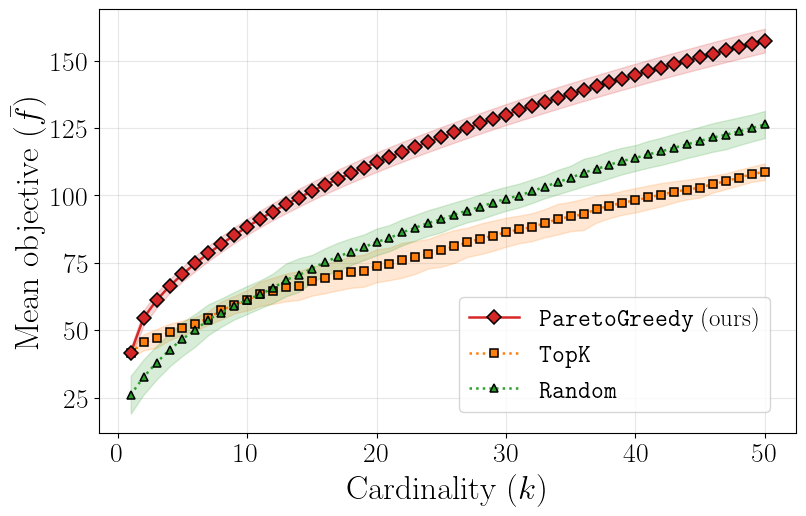

2026-01-26 17:01:02,016 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy: 3.998 ± 0.216
  - TopK: 0.558 ± 0.011
  - Random: 0.266 ± 0.012


In [6]:
#Adjust parameters as needed
sample_size = 500
num_runs = 15  #number of random runs
k_max = 50
findApproximateParetoSolutions(vegas_simMatrix, vegas_ids, sample_size, num_runs, k_max, "Yelp_Vegas")